<img src="../static/images/joinnode.png"  width="240">

# JoinNode

JoinNode have the opposite effect of [iterables](basic_iteration.ipynb). Where `iterables` split up the execution workflow into many different branches, a JoinNode merges them back into on node. For a more detailed explanation, check out [JoinNode, synchronize and itersource](http://nipype.readthedocs.io/en/latest/users/joinnode_and_itersource.html) from the main homepage.

## Simple example

Let's consider the very simple example depicted at the top of this page:

```python
from nipype import Node, JoinNode, Workflow

# Specify fake input node A
a = Node(interface=A(), name="a")

# Iterate over fake node B's input 'in_file?
b = Node(interface=B(), name="b")
b.iterables = ('in_file', [file1, file2])

# Pass results on to fake node C
c = Node(interface=C(), name="c")

# Join forked execution workflow in fake node D
d = JoinNode(interface=D(),
             joinsource="b",
             joinfield="in_files",
             name="d")

# Put everything into a workflow as usual
workflow = Workflow(name="workflow")
workflow.connect([(a, b, [('subject', 'subject')]),
                  (b, c, [('out_file', 'in_file')])
                  (c, d, [('out_file', 'in_files')])
                  ])
```

As you can see, setting up a ``JoinNode`` is rather simple. The only difference to a normal ``Node`` are the ``joinsource`` and the ``joinfield``. ``joinsource`` specifies from which node the information to join is coming and the ``joinfield`` specifies the input field of the JoinNode where the information to join will be entering the node.

## More realistic example

Let's consider another example where we have one node that iterates over 3 different numbers and generates randome numbers. Another node joins those three different numbers (each coming from a separate branch of the workflow) into one list. To make the whole thing a bit more realistic, the second node will use the ``Function`` interface to do something with those numbers, before we spit them out again.

In [1]:
from nipype import JoinNode, Node, Workflow
from nipype.interfaces.utility import Function, IdentityInterface

In [2]:
def get_data_from_id(id):
    """Generate a random number based on id"""
    import numpy as np
    return id + np.random.rand()

def merge_and_scale_data(data2):
    """Scale the input list by 1000"""
    import numpy as np
    return (np.array(data2) * 1000).tolist()


node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='scale_data',
                 joinsource=node1,
                 joinfield=['data2'])

In [3]:
wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
eg = wf.run()

170730-13:16:00,459 workflow INFO:
	 Workflow testjoin settings: ['check', 'execution', 'logging']
170730-13:16:00,476 workflow INFO:
	 Running serially.
170730-13:16:00,477 workflow INFO:
	 Executing node get_data.aI.a2 in dir: /tmp/tmplqr0wciy/testjoin/_id_3/get_data
170730-13:16:00,486 workflow INFO:
	 Executing node get_data.aI.a1 in dir: /tmp/tmphcih9m3b/testjoin/_id_2/get_data
170730-13:16:00,494 workflow INFO:
	 Executing node get_data.aI.a0 in dir: /tmp/tmpmcjlfgo3/testjoin/_id_1/get_data
170730-13:16:00,502 workflow INFO:
	 Executing node scale_data in dir: /tmp/tmplr1jdbwn/testjoin/scale_data


170730-13:16:00,622 workflow INFO:
	 Generated workflow graph: /opt/tutorial/notebooks/graph.dot.png (graph2use=exec, simple_form=True).


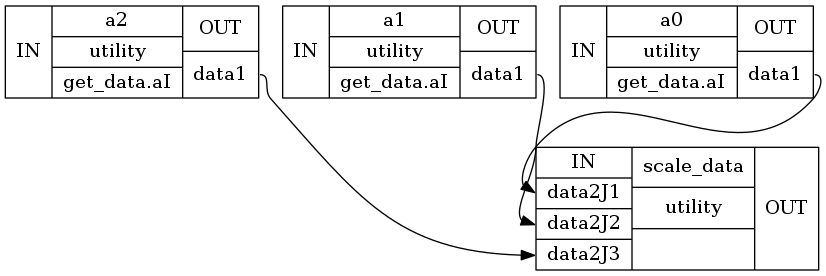

In [4]:
wf.write_graph(graph2use='exec')
from IPython.display import Image
Image(filename='graph_detailed.dot.png')

Now, let's look at the input and output of the joinnode:

In [5]:
res = [node for node in eg.nodes() if 'scale_data' in node.name][0].result
res.outputs


data_scaled = [1795.2487567691367, 2150.8928352505777, 3077.808283218675]

In [6]:
res.inputs

{'data2': [1.7952487567691366, 2.150892835250578, 3.0778082832186753],
 'function_str': 'def merge_and_scale_data(data2):\n    """Scale the input list by 1000"""\n    import numpy as np\n    return (np.array(data2) * 1000).tolist()\n',
 'ignore_exception': False}

## Extending to multiple nodes

We extend the workflow by using three nodes. Note that even this workflow, the joinsource corresponds to the node containing iterables and the joinfield corresponds to the input port of the JoinNode that aggregates the iterable branches. As before the graph below shows how the execution process is setup.

In [7]:
def get_data_from_id(id):
    import numpy as np
    return id + np.random.rand()

def scale_data(data2):
    import numpy as np
    return data2

def replicate(data3, nreps=2):
    return data3 * nreps

node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = Node(Function(input_names=['data2'],
                      output_names=['data_scaled'],
                      function=scale_data),
             name='scale_data')

node3 = JoinNode(Function(input_names=['data3'],
                          output_names=['data_repeated'],
                          function=replicate),
                 name='replicate_data',
                 joinsource=node1,
                 joinfield=['data3'])

In [8]:
wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
wf.connect(node2, 'data_scaled', node3, 'data3')
eg = wf.run()

170730-13:16:00,687 workflow INFO:
	 Workflow testjoin settings: ['check', 'execution', 'logging']
170730-13:16:00,708 workflow INFO:
	 Running serially.
170730-13:16:00,710 workflow INFO:
	 Executing node get_data.aI.a2 in dir: /tmp/tmposssqhq1/testjoin/_id_3/get_data
170730-13:16:00,719 workflow INFO:
	 Executing node scale_data.a2 in dir: /tmp/tmp5z1tfm1h/testjoin/_id_3/scale_data
170730-13:16:00,726 workflow INFO:
	 Executing node get_data.aI.a1 in dir: /tmp/tmp05pdhges/testjoin/_id_2/get_data
170730-13:16:00,734 workflow INFO:
	 Executing node scale_data.a1 in dir: /tmp/tmpw3f747_0/testjoin/_id_2/scale_data
170730-13:16:00,741 workflow INFO:
	 Executing node get_data.aI.a0 in dir: /tmp/tmp9nddmve7/testjoin/_id_1/get_data
170730-13:16:00,748 workflow INFO:
	 Executing node scale_data.a0 in dir: /tmp/tmp_nlv4agg/testjoin/_id_1/scale_data
170730-13:16:00,756 workflow INFO:
	 Executing node replicate_data in dir: /tmp/tmpn5jc0uwa/testjoin/replicate_data


170730-13:16:00,892 workflow INFO:
	 Generated workflow graph: /opt/tutorial/notebooks/graph.dot.png (graph2use=exec, simple_form=True).


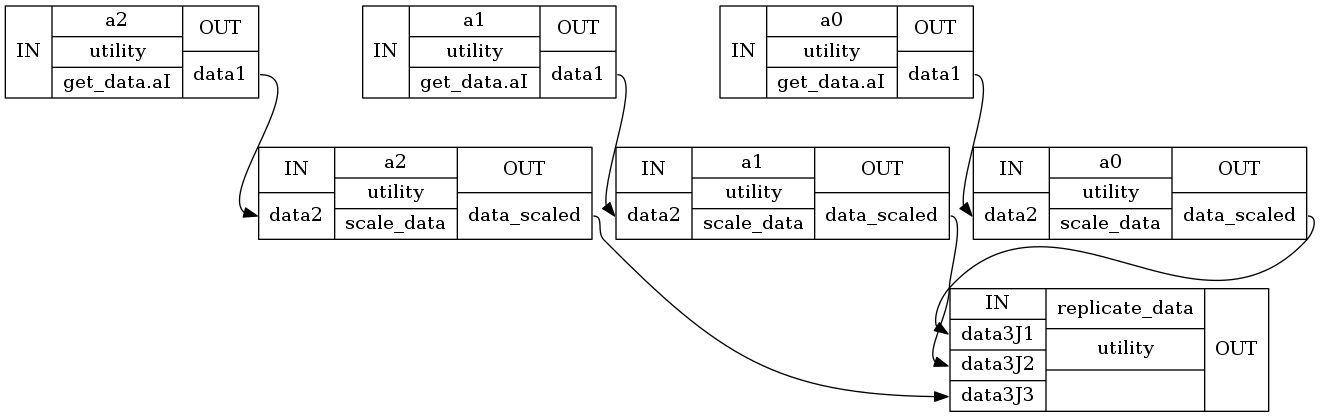

In [9]:
wf.write_graph(graph2use='exec')
Image(filename='graph_detailed.dot.png')